In [87]:
import pandas as pd
import numpy as np
from config import db_password
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('Dark2')

# Initial imports.
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
# create database connection
import psycopg2
connection = psycopg2.connect(
    host = 'projectanimal.c2jqqtcm0i1p.us-east-2.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = db_password,
    database='projectanimal'
    )
cursor=connection.cursor()

In [60]:
# import intake data
sql = '''
select * from animal_intake'''

intake_df = pd.read_sql(sql,con=connection)
intake_df.head()

,animal_id,name_intake,datetime_intake,found_location,intake_type,intake_condition,animal_type_intake,sex_intake,color_intake,breed_type
0,A730601,No,2016-07-07 12:11:00,"1109 Shady Ln, Austin (TX)",Stray,Normal,Cat,Intact Male,Tabby,Mix
1,A683644,Yes,2014-07-13 11:02:00,,Owner Surrender,Maternity,Dog,Intact Female,Brown,Herding Dogs
2,A676515,Yes,2014-04-11 08:45:00,"615 E. Wonsley, Austin (TX)",Stray,Normal,Dog,Intact Male,Brown,Bully Dogs
3,A742953,No,2017-01-31 13:30:00,,Stray,Normal,Dog,Intact Male,Brown,Hound Dogs
4,A679549,Yes,2014-05-22 15:43:00,"124 W Anderson, Austin (TX)",Stray,Normal,Cat,Intact Male,Black,Mix


In [61]:
# import outcome data
sql = '''
select * from animal_outcome'''

outcome_df = pd.read_sql(sql,con=connection)
outcome_df.head()

,animal_id,datetime_outcome,outcome_type,sex_upon_outcome,fixed_changed,age_bucket,length_of_stay
0,A730601,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,0.8673611111111111
1,A683644,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,115.96111111111111
2,A676515,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,3.4118055555555555
3,A742953,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,4.032638888888889
4,A679549,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,24.924305555555556


In [62]:
# merge data
df = intake_df.merge(outcome_df, on='animal_id', how='left')
df.head()

,animal_id,name_intake,datetime_intake,found_location,intake_type,intake_condition,animal_type_intake,sex_intake,color_intake,breed_type,datetime_outcome,outcome_type,sex_upon_outcome,fixed_changed,age_bucket,length_of_stay
0,A730601,No,2016-07-07 12:11:00,"1109 Shady Ln, Austin (TX)",Stray,Normal,Cat,Intact Male,Tabby,Mix,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,0.8673611111111111
1,A683644,Yes,2014-07-13 11:02:00,,Owner Surrender,Maternity,Dog,Intact Female,Brown,Herding Dogs,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,115.96111111111111
2,A676515,Yes,2014-04-11 08:45:00,"615 E. Wonsley, Austin (TX)",Stray,Normal,Dog,Intact Male,Brown,Bully Dogs,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,3.4118055555555555
3,A742953,No,2017-01-31 13:30:00,,Stray,Normal,Dog,Intact Male,Brown,Hound Dogs,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,4.032638888888889
4,A679549,Yes,2014-05-22 15:43:00,"124 W Anderson, Austin (TX)",Stray,Normal,Cat,Intact Male,Black,Mix,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,24.924305555555556


# Preprocessing Data

In [63]:
# Check for null values
df.isnull().sum()

animal_id             0
name_intake           0
datetime_intake       0
found_location        0
intake_type           0
intake_condition      0
animal_type_intake    0
sex_intake            0
color_intake          0
breed_type            0
datetime_outcome      0
outcome_type          0
sex_upon_outcome      0
fixed_changed         0
age_bucket            0
length_of_stay        0
dtype: int64

In [64]:
# Check for duplicates rows
count=0
for i in df['animal_id'].duplicated():
    if i is True:
        count+=1
count

0

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55771 entries, 0 to 55770
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   animal_id           55771 non-null  object        
 1   name_intake         55771 non-null  object        
 2   datetime_intake     55771 non-null  datetime64[ns]
 3   found_location      55771 non-null  object        
 4   intake_type         55771 non-null  object        
 5   intake_condition    55771 non-null  object        
 6   animal_type_intake  55771 non-null  object        
 7   sex_intake          55771 non-null  object        
 8   color_intake        55771 non-null  object        
 9   breed_type          55771 non-null  object        
 10  datetime_outcome    55771 non-null  datetime64[ns]
 11  outcome_type        55771 non-null  object        
 12  sex_upon_outcome    55771 non-null  object        
 13  fixed_changed       55771 non-null  object    

## Target Variable 

In [66]:
# review target values
df.outcome_type.value_counts()

Adoption           22267
Transfer           18258
Return to Owner     9380
Euthanasia          5085
Died                 781
Name: outcome_type, dtype: int64

In [67]:
# combine Euthanasia and Died as there are few values for Died
df.loc[(df.outcome_type == 'Died') | (df.outcome_type == 'Euthanasia'), 'outcome_type'] = 'Died'

<AxesSubplot:xlabel='outcome_type', ylabel='count'>

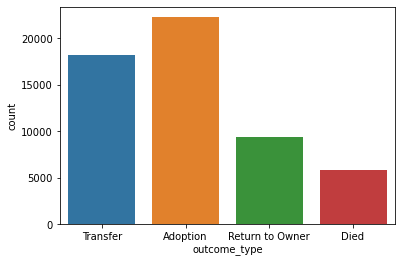

In [68]:
sns.countplot(x=df.outcome_type)

## Feature Variables

In [82]:
def plotCat (df, col):
    plt.figure(figsize=(14,5))
    plt.suptitle(col, fontsize=20)
    sns.countplot(x=df['outcome_type'], hue=df[col])

In [70]:
def plotNum (df, col):
    plt.figure(figsize=(14,5))
    plt.suptitle(col, fontsize=20)
    plt.subplot(1,2,1)
    sns.boxplot(data=df, x='outcome_type', y=col)
    plt.subplot(1,2,2)
    sns.histplot(df[col].dropna(), bins=20)

In [71]:
# change length_of_stay to float data type
df.length_of_stay = df.length_of_stay.apply(pd.to_numeric)

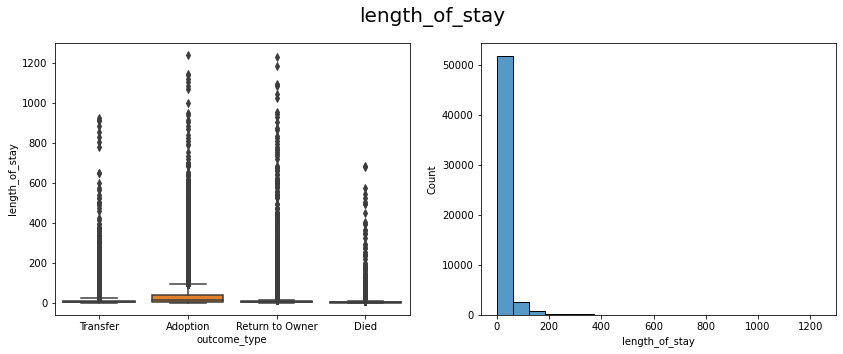

In [72]:
plotNum(df, 'length_of_stay')

In [73]:
# check number of values in color_intake
df.color_intake.value_counts()

Black       16551
Tabby       10259
Brown        7312
White        6479
Calico       3084
Blue         2950
Red          2209
Brindle      1944
Tricolor     1476
Orange       1436
Point         914
Gray          551
Merle         548
Other          58
Name: color_intake, dtype: int64

In [75]:
# bucket values less then 1,000 to Other to reduce number of values
color_counts=df['color_intake'].value_counts()
replace_color=color_counts.loc[color_counts<1000].index.tolist()
for i in replace_color:
    df.color_intake = df.color_intake.replace(i,"Other")

df.color_intake.value_counts()

Black       16551
Tabby       10259
Brown        7312
White        6479
Calico       3084
Blue         2950
Red          2209
Other        2071
Brindle      1944
Tricolor     1476
Orange       1436
Name: color_intake, dtype: int64

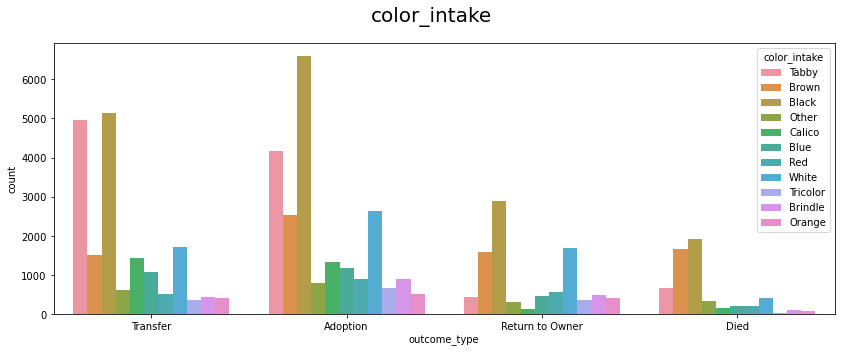

In [88]:
plotCat(df, 'color_intake')

In [84]:
# check number of values in breed_type
df.breed_type.value_counts()

Mix                 30352
Bully Dogs           5304
Chihuahua            4932
Retriever Breeds     4832
Herding Dogs         2640
Other Dogs           2229
Terrier Dogs         2196
Small Dogs           1440
Wildlife             1060
Other Cats            610
Other                 176
Name: breed_type, dtype: int64

In [85]:
# bucket values less then 700 to Other to reduce number of values
df.loc[(df.breed_type == 'Hound Dogs') | 
       (df.breed_type == 'Sporting Dogs') | 
       (df.breed_type == 'Husky Dogs') |
       (df.breed_type == 'X Large Dogs') |
       (df.breed_type == 'German Shepherd') |
       (df.breed_type == 'Working Dogs'), 'breed_type'] = 'Other Dogs'
df.loc[(df.breed_type == 'Domestic Shorthair Cat') |
       (df.breed_type == 'Other Cat') |
       (df.breed_type == 'Domestic Medium Hair Cat'), 'breed_type'] = 'Other Cats'
df.breed_type.value_counts()

Mix                 30352
Bully Dogs           5304
Chihuahua            4932
Retriever Breeds     4832
Herding Dogs         2640
Other Dogs           2229
Terrier Dogs         2196
Small Dogs           1440
Wildlife             1060
Other Cats            610
Other                 176
Name: breed_type, dtype: int64

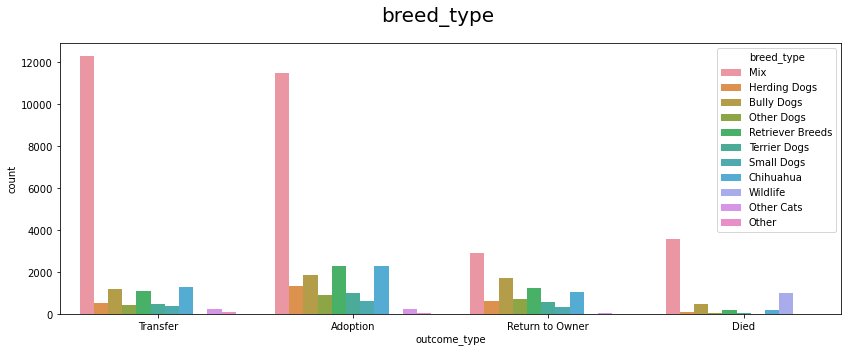

In [86]:
plotCat(df, 'breed_type')

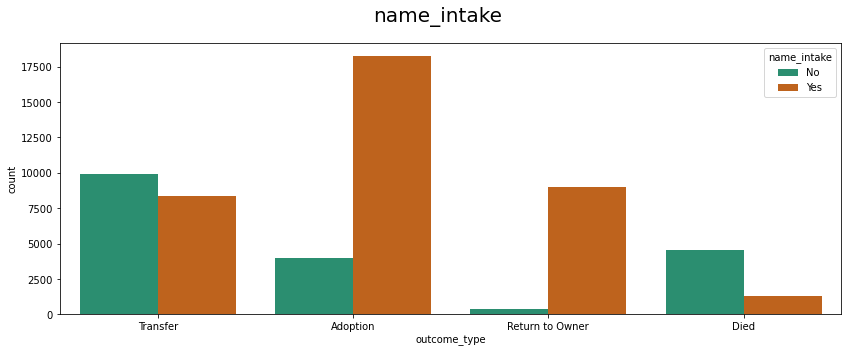

In [89]:
plotCat(df, 'name_intake')

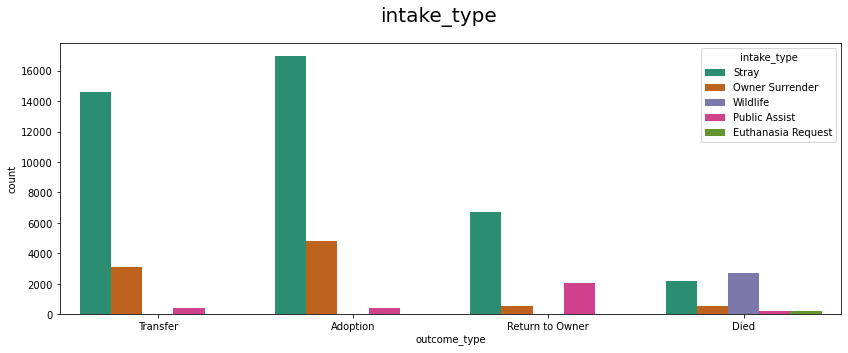

In [90]:
plotCat(df, 'intake_type')

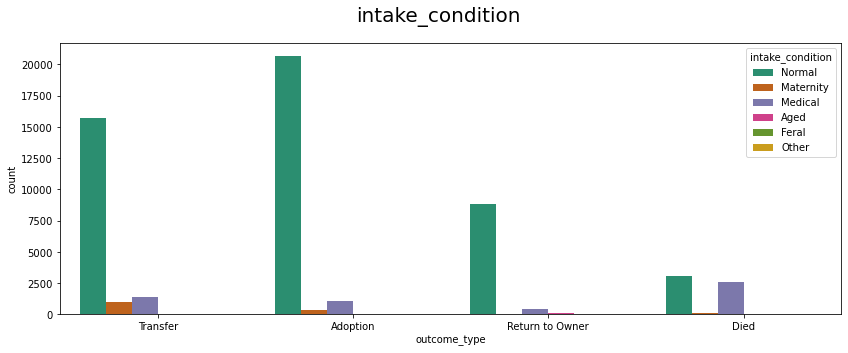

In [91]:
plotCat(df, 'intake_condition')

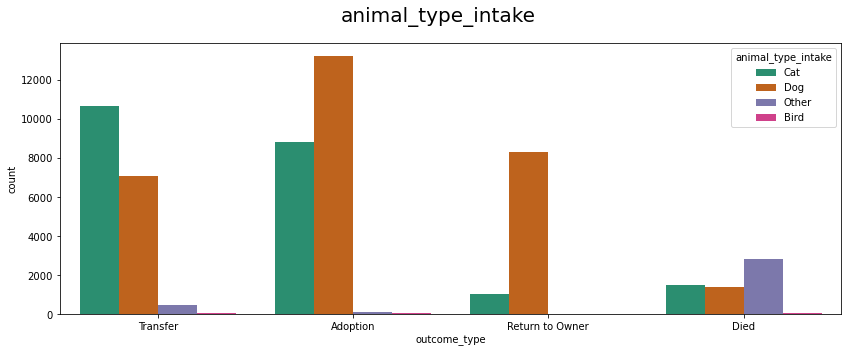

In [92]:
plotCat(df, 'animal_type_intake')

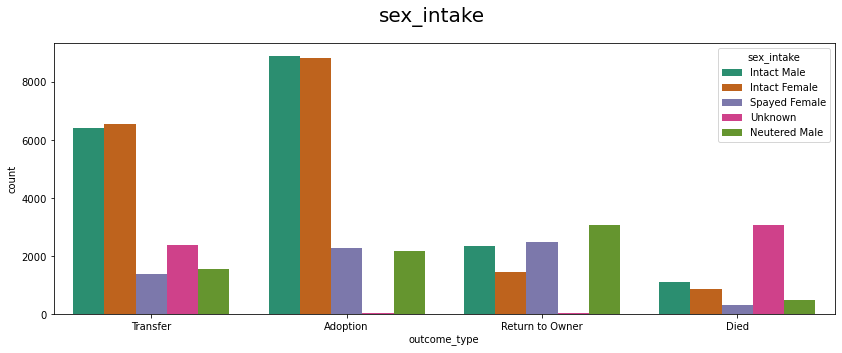

In [93]:
plotCat(df, 'sex_intake')

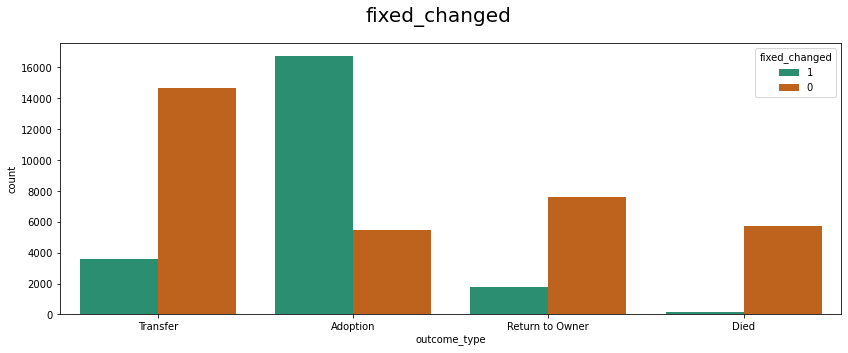

In [94]:
plotCat(df, 'fixed_changed')

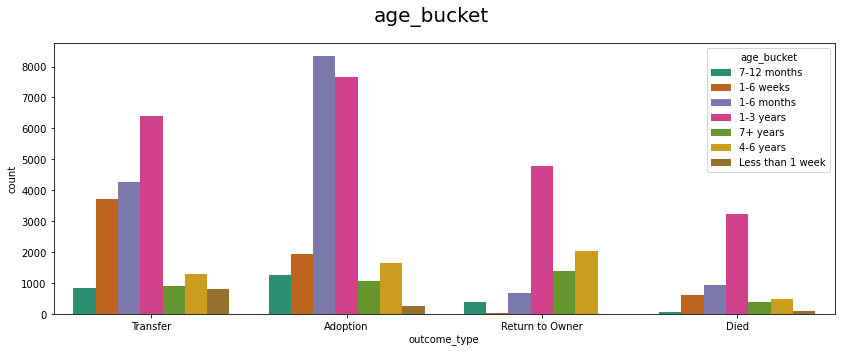

In [95]:
plotCat(df, 'age_bucket')

In [96]:
# Drop unnecessary columns and columns with large number of unique values
df.drop(columns=['animal_id','found_location','datetime_intake','datetime_outcome', 'sex_upon_outcome'], axis=1, inplace=True)
df.head()

,name_intake,intake_type,intake_condition,animal_type_intake,sex_intake,color_intake,breed_type,outcome_type,fixed_changed,age_bucket,length_of_stay
0,No,Stray,Normal,Cat,Intact Male,Tabby,Mix,Transfer,1,7-12 months,0.867361
1,Yes,Owner Surrender,Maternity,Dog,Intact Female,Brown,Herding Dogs,Adoption,1,1-6 weeks,115.961111
2,Yes,Stray,Normal,Dog,Intact Male,Brown,Bully Dogs,Return to Owner,1,1-6 months,3.411806
3,No,Stray,Normal,Dog,Intact Male,Brown,Other Dogs,Transfer,0,1-3 years,4.032639
4,Yes,Stray,Normal,Cat,Intact Male,Black,Mix,Transfer,1,1-6 months,24.924306


## Label Encoding

In [97]:
# encode text columns with dummy values
df_encoded = pd.get_dummies(df, columns=['name_intake',
                                         'intake_type',
                                         'intake_condition',
                                         'animal_type_intake',
                                         'color_intake',
                                         'sex_intake',
                                         'age_bucket',
                                         'breed_type'])

In [98]:
# encode target 
le = LabelEncoder()
df_encoded['outcome_type'] = le.fit_transform(df_encoded['outcome_type'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Adoption': 0, 'Died': 1, 'Return to Owner': 2, 'Transfer': 3}


In [99]:
df_encoded.head()

,outcome_type,fixed_changed,length_of_stay,name_intake_No,name_intake_Yes,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,...,breed_type_Chihuahua,breed_type_Herding Dogs,breed_type_Mix,breed_type_Other,breed_type_Other Cats,breed_type_Other Dogs,breed_type_Retriever Breeds,breed_type_Small Dogs,breed_type_Terrier Dogs,breed_type_Wildlife
0,3,1,0.867361,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,115.961111,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,1,3.411806,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,4.032639,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,3,1,24.924306,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


## Train Test Split

In [100]:
# Define the features set.
X=df_encoded.drop('outcome_type',axis=1)

In [101]:
# Define the target set.
y = df_encoded["outcome_type"].ravel()

In [102]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

## Scaling Data

In [103]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Resampling

In [104]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Machine Learning Models

## Random Forest Classification

In [105]:
# initialize model, fit and predict
rf_model = RandomForestClassifier(n_estimators=128) 
rf_model = rf_model.fit(X_resampled, y_resampled)
rf_pred = rf_model.predict(X_test_scaled)

In [106]:
# View Results
results = pd.DataFrame({
   "Prediction": rf_pred,
   "Actual": y_test
}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,1,1
2,0,0
3,1,1
4,2,0


In [108]:
# print confusion matrix
cm = confusion_matrix(rf_pred, y_test)
cm_df = pd.DataFrame(cm,
                     index = ['Adoption', 'Died', 'Return to Owner','Transfer'], 
                     columns = ['Adoption', 'Died', 'Return to Owner','Transfer'])
cm_df

,Adoption,Died,Return to Owner,Transfer
Adoption,4433,46,235,981
Died,169,1098,80,331
Return to Owner,456,74,1934,320
Transfer,481,212,110,2983


In [109]:
# print classification report
print(classification_report(rf_pred, y_test, target_names=['Adoption', 'Died', 'Return to Owner','Transfer']))

                 precision    recall  f1-score   support

       Adoption       0.80      0.78      0.79      5695
           Died       0.77      0.65      0.71      1678
Return to Owner       0.82      0.69      0.75      2784
       Transfer       0.65      0.79      0.71      3786

       accuracy                           0.75     13943
      macro avg       0.76      0.73      0.74     13943
   weighted avg       0.76      0.75      0.75     13943



<AxesSubplot:title={'center':'Feature Importance'}>

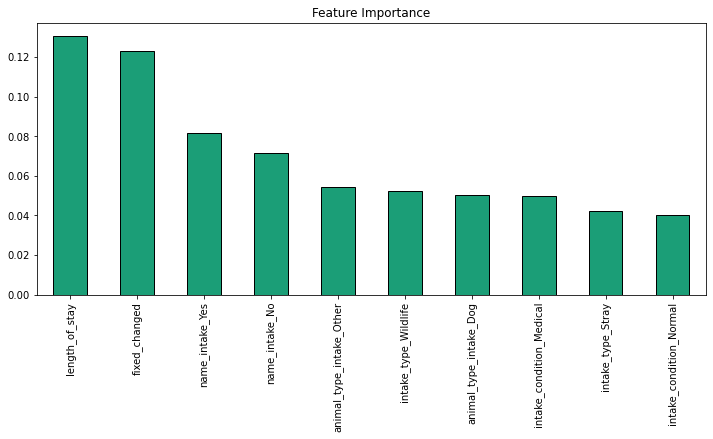

In [110]:
# show feature importance
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='bar', figsize=(12,5), cmap='Dark2', edgecolor='black', title='Feature Importance')
# plt.xticks(rotation=65)

# Gradient Boosting Classification

In [111]:
# initialize model, fit and predict
gb_model = GradientBoostingClassifier(n_estimators=20,
   learning_rate=0.5, max_features=5, max_depth=3)
gb_model.fit(X_resampled, y_resampled)
gb_pred = gb_model.predict(X_test_scaled)

In [112]:
# View Results
results = pd.DataFrame({
   "Prediction": gb_pred,
   "Actual": y_test
}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,1,1
2,0,0
3,1,1
4,2,0


In [113]:
# print confusion matrix
cm = confusion_matrix(gb_pred, y_test)
cm_df = pd.DataFrame(cm,
                     index = ['Adoption', 'Died', 'Return to Owner','Transfer'], 
                     columns = ['Adoption', 'Died', 'Return to Owner','Transfer'])
cm_df

,Adoption,Died,Return to Owner,Transfer
Adoption,4336,45,175,957
Died,190,1073,75,420
Return to Owner,599,83,1988,492
Transfer,414,229,121,2746


In [114]:
# print classification report
print(classification_report(gb_pred, y_test, target_names=['Adoption', 'Died', 'Return to Owner','Transfer']))

                 precision    recall  f1-score   support

       Adoption       0.78      0.79      0.78      5513
           Died       0.75      0.61      0.67      1758
Return to Owner       0.84      0.63      0.72      3162
       Transfer       0.60      0.78      0.68      3510

       accuracy                           0.73     13943
      macro avg       0.74      0.70      0.71     13943
   weighted avg       0.75      0.73      0.73     13943



<AxesSubplot:title={'center':'Feature Importance'}>

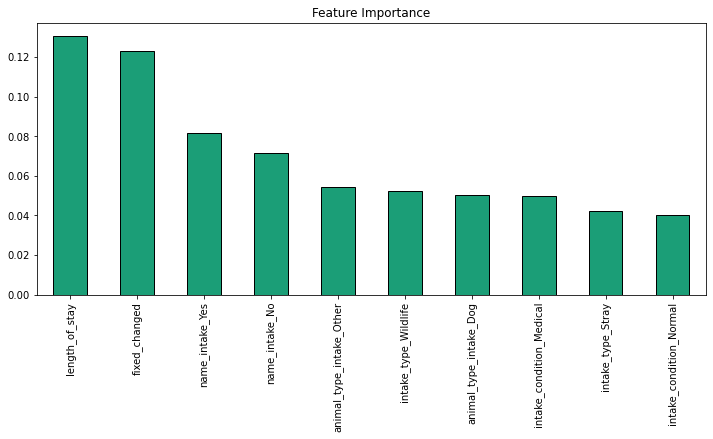

In [115]:
# show feature importance
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='bar', figsize=(12,5), cmap='Dark2', edgecolor='black', title='Feature Importance')
# plt.xticks(rotation=65)

## KNeighbors Classification

In [116]:
# initialize model, fit and predict
k_model = KNeighborsClassifier(n_neighbors=10)
k_model.fit(X_resampled, y_resampled)
k_pred = k_model.predict(X_test_scaled)

In [118]:
# View Results
results = pd.DataFrame({
   "Prediction": k_pred,
   "Actual": y_test
}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,1,1
2,0,0
3,1,1
4,2,0


In [117]:
# print confusion matrix
cm = confusion_matrix(k_pred, y_test)
cm_df = pd.DataFrame(cm,
                     index = ['Adoption', 'Died', 'Return to Owner','Transfer'], 
                     columns = ['Adoption', 'Died', 'Return to Owner','Transfer'])
cm_df

,Adoption,Died,Return to Owner,Transfer
Adoption,3620,62,259,978
Died,218,1068,106,364
Return to Owner,1294,148,1921,821
Transfer,407,152,73,2452


In [119]:
# print classification report
print(classification_report(k_pred, y_test, target_names=['Adoption', 'Died', 'Return to Owner','Transfer']))

                 precision    recall  f1-score   support

       Adoption       0.65      0.74      0.69      4919
           Died       0.75      0.61      0.67      1756
Return to Owner       0.81      0.46      0.59      4184
       Transfer       0.53      0.80      0.64      3084

       accuracy                           0.65     13943
      macro avg       0.69      0.65      0.65     13943
   weighted avg       0.69      0.65      0.65     13943

